In [56]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date, timedelta
print("Setup Complete")

Setup Complete


In [57]:
covid_filepath = 'Agreguoti_COVID19_atvejai_ir_mirtys.csv'
covid_data = pd.read_csv(covid_filepath, parse_dates = True)
population_filepath = 'Nuolatiniu_gyventoju_skaicius_metu_pradzioje.csv'
population_data = pd.read_csv(population_filepath)

In [58]:
covid_data.head(10)

,object_id,municipality_name,date,sex,age_gr,new_cases,deaths_all,deaths_cov1,deaths_cov2,deaths_cov3
0,1,Vilniaus m. sav.,2022-04-21,Moteris,0-9,7,0,0,0,0
1,2,Vilniaus m. sav.,2022-04-21,Moteris,10-19,11,0,0,0,0
2,3,Vilniaus m. sav.,2022-04-21,Moteris,20-29,35,0,0,0,0
3,4,Vilniaus m. sav.,2022-04-21,Moteris,30-39,36,0,0,0,0
4,5,Vilniaus m. sav.,2022-04-21,Moteris,40-49,24,0,0,0,0
5,6,Vilniaus m. sav.,2022-04-21,Moteris,50-59,25,0,0,0,0
6,7,Vilniaus m. sav.,2022-04-21,Moteris,60-69,28,1,0,0,0
7,8,Vilniaus m. sav.,2022-04-21,Moteris,70-79,16,0,0,0,0
8,9,Vilniaus m. sav.,2022-04-21,Moteris,80-89,3,7,0,1,1
9,10,Vilniaus m. sav.,2022-04-21,Moteris,90-99,3,1,0,0,0


In [59]:
# Tikrinam datos formata
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289169 entries, 0 to 289168
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   object_id          289169 non-null  int64 
 1   municipality_name  289169 non-null  object
 2   date               289169 non-null  object
 3   sex                289169 non-null  object
 4   age_gr             289169 non-null  object
 5   new_cases          289169 non-null  int64 
 6   deaths_all         289169 non-null  int64 
 7   deaths_cov1        289169 non-null  int64 
 8   deaths_cov2        289169 non-null  int64 
 9   deaths_cov3        289169 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.1+ MB


In [60]:
# Konvertuojam data i datetime formata ir nustatome kaip index'a
date_col = 'date'
covid_data[date_col] = pd.to_datetime(covid_data[date_col])
covid_data = covid_data.set_index(date_col)
covid_data = covid_data.sort_index()

In [61]:
covid_data.head()

,object_id,municipality_name,sex,age_gr,new_cases,deaths_all,deaths_cov1,deaths_cov2,deaths_cov3
date,,,,,,,,,
2020-02-01,245667,Telšių r. sav.,Moteris,60-69,0,1,0,0,0
2020-02-01,143892,Kupiškio r. sav.,Vyras,50-59,0,1,0,0,0
2020-02-01,31754,Klaipėdos m. sav.,Moteris,80-89,0,3,0,0,0
2020-02-01,206277,Skuodo r. sav.,Moteris,80-89,0,1,0,0,0
2020-02-01,140820,Kretingos r. sav.,Vyras,70-79,0,1,0,0,0


In [62]:
# 2.1 Identifikuojam pandemijos 60 dienų intervalą, kurio metu bendras mirtingumas (duomenų stulpelis all_deaths) Lietuvoje buvo pats didžiausias

interval_data = covid_data.resample('D').sum()
interval_data['60days_rsum'] = interval_data['deaths_all'].rolling('60D').sum()

# Randam kuriai dienai rodiklis buvo didziausias
max_rsum = interval_data['60days_rsum'].max()
print(max_rsum)   # 10616.0
# Surandam rodiklio data
print(interval_data.loc[interval_data['60days_rsum'] == max_rsum])   # 2021-01-18
# Apskaiciuojam 60 d. laikotarpio start date
finish_date = date(2021,1,18)
start_date = finish_date - timedelta(60)

print('Laikotarpio pradžios data: ', start_date)
print('Laikotarpio pabaigos data: ', finish_date)

10616.0
            object_id  new_cases  deaths_all  deaths_cov1  deaths_cov2  \
date                                                                     
2021-01-18   55618763        830         165           23           37   

            deaths_cov3  60days_rsum  
date                                  
2021-01-18           51      10616.0  
Laikotarpio pradžios data:  2020-11-19
Laikotarpio pabaigos data:  2021-01-18


In [63]:
# 2.2

# Trinam eilutes kur vietove nenustatyta
high_covid_data = covid_data[covid_data.municipality_name != 'Nenustatyta']
# Sumuojam mirciu skaiciu pagal data ir vietove
high_covid_data = high_covid_data.groupby('municipality_name').resample('D').sum().reset_index(drop=False)
# Pridedam ir apskaiciuojam stulpeli su akumuliuota suma
high_covid_data['roll_sum'] = high_covid_data.groupby(['municipality_name'])['deaths_all'].cumsum()
# Isrenkam tik identifikuota laikuotarpi (2.1 uzduotis)
high_covid_data = high_covid_data.set_index(date_col)
high_covid_data = high_covid_data.loc['2020-11-19':'2021-01-18']
high_covid_data.reset_index(inplace=True)

In [64]:
# Is nuolatiniu gyventoju pagal savivaldybes pasiimam duomenis 2021 m. pradzios
population_data_2021 = population_data.loc[population_data['laikotarpis'] == 2021]
population_data_2021 = population_data_2021[['laikotarpis','municipality_name','population']]
population_data_2021 = population_data_2021[population_data_2021.municipality_name != 'Lietuvos Respublika']
population_data_2021.head()

,laikotarpis,municipality_name,population
4,2021,Elektrėnų sav.,24108.0
7,2021,Šalčininkų r. sav.,30274.0
10,2021,Širvintų r. sav.,14910.0
13,2021,Švenčionių r. sav.,22493.0
16,2021,Trakų r. sav.,33213.0


In [65]:
# Sujungiam covid ir gyventoju skaiciu lenteles
# Normaliziuojam rodikli 100.000 gyv.
final_data = pd.merge(high_covid_data,population_data_2021, on='municipality_name', how='inner')
final_data['death_per_100000'] = final_data['roll_sum'] / final_data['population'] * 100000

In [66]:
# Apskaiciuojam savivaldybiu reitinga (1 - maziausias mirciu skaicius)
final_data['rank'] = final_data.groupby('date')['death_per_100000'].rank('first')

In [67]:
# Legendos eiliskumas
ranked_mun = final_data[final_data['date'] == '2021-01-18']
ranked_mun = ranked_mun.sort_values('rank', ascending=False)
sorted_ranked_mun = ranked_mun['municipality_name'].tolist()

In [68]:
# Atrenkam top 10 savivaldybiu ir kt.savivaldybes
top10 = final_data[(final_data['rank'] > 50) & (final_data['date'] == '2021-01-18')]
top10_mun = top10['municipality_name'].tolist()
high_municipality = final_data.loc[final_data['municipality_name'].isin(top10_mun)]
rest_municipality = final_data.loc[~final_data['municipality_name'].isin(top10_mun)]


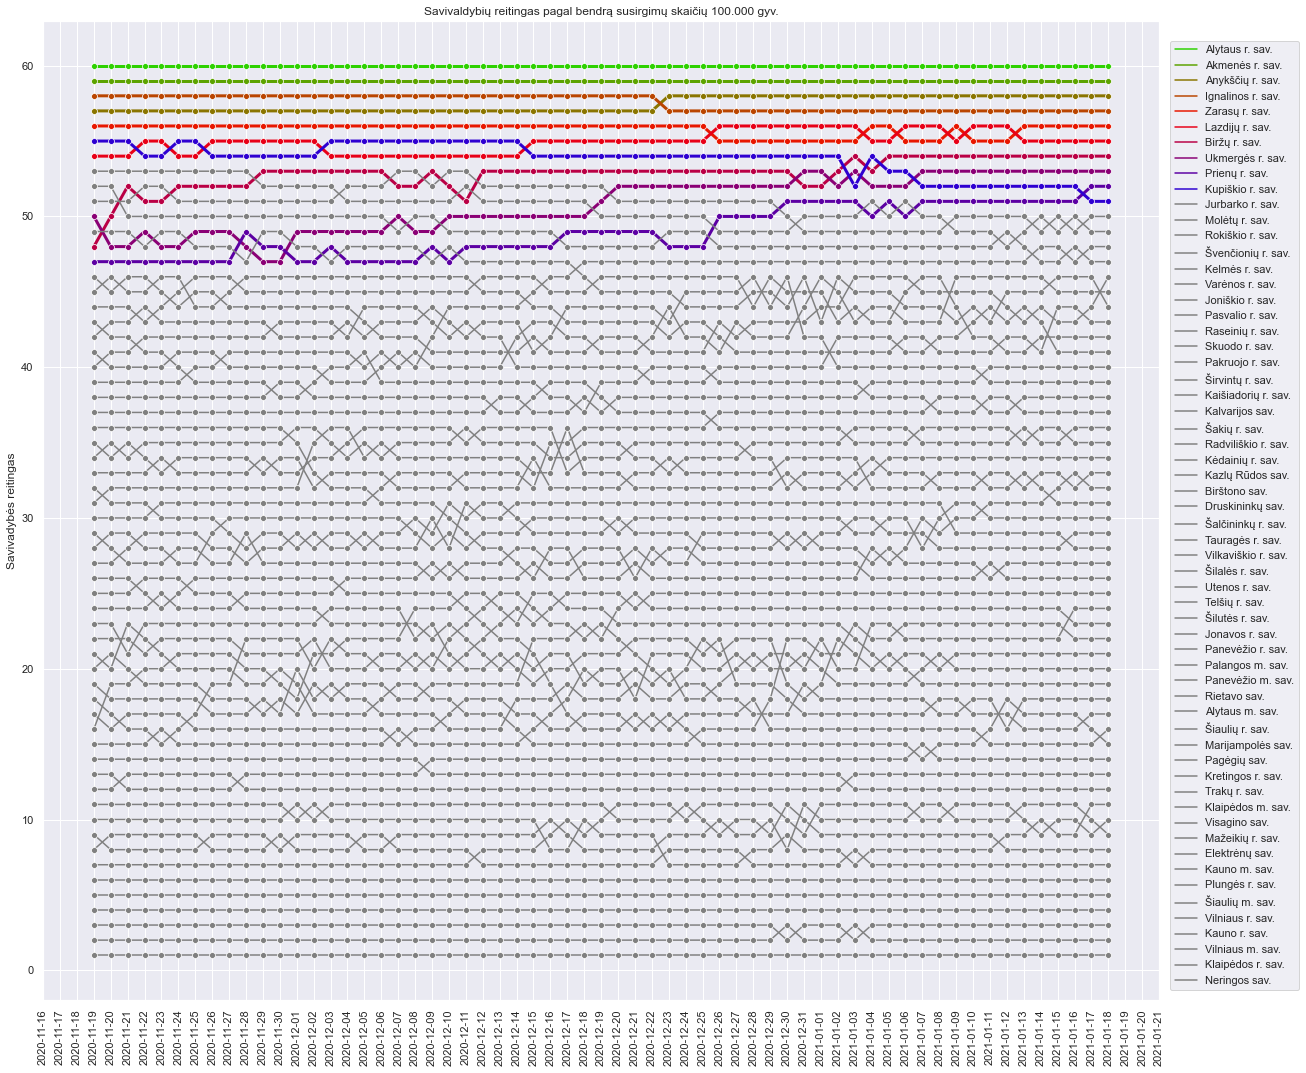

In [69]:
# Grafikas
sns.set_style('dark')
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize = (20,18))
plt.title('Savivaldybių reitingas pagal bendrą susirgimų skaičių 100.000 gyv.')
sns.lineplot(data=high_municipality, x='date', y='rank', hue='municipality_name', ci = None, ax = ax, marker='o', linewidth=3, palette='brg_r', hue_order=sorted_ranked_mun[:10])
color_line = ['grey']*50
sns.lineplot(data=rest_municipality, x='date', y='rank', hue='municipality_name', ci = None, ax = ax, marker='o', palette=color_line, hue_order=sorted_ranked_mun[10:])
plt.legend(bbox_to_anchor=(1.01, 0.98), loc='upper left', borderaxespad=0, )

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.tick_params(axis="x", rotation=90)
plt.ylabel('Savivadybės reitingas')
plt.xlabel('')
plt.show()